## Batch normalisation

Batch normalisation ([Ioffe & Szegedy 2015](#Ioffe15)) is a widely used method in deep learning. It is used to normalise the distribution of internal activation values in the network.

The core issue is that of **covariate shift**, which is the change in distribution of input variables to a machine learning model. This can happen in datasets where there is some change in conditions in subsequent data collections, for example over time or location. Whilst the underlying target function might not have changed, the distribution of the input variables does change which means the model could perform poorly in the changed conditions.

An example could be collected data regarding how people are feeling about christmas (scale: 1-10). If you collected data in 2015 and then collected data in 2019 (during pandemic) results would be very different even though the target - how people feel about christmas - remains the same!

The following shows a simple example of a regression function that fails to generalise to new data points whose distribution has shifted from the training data, even though the underlying target function is the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

def target(x):
    return x**3 - 15 * x - 12

#create our data and remove first 30 pts (saved in train_sub)
n_samples = 100
x_train_all = np.linspace(-5, 5, n_samples)[..., np.newaxis]
x_train_sub = x_train_all[30:]
y_train_all = target(x_train_all) + 10 * np.random.randn(n_samples, 1)
y_train_sub = y_train_all[30:]

#apply kernal ridge regression to train_sub (without first 30 pts) 
kernel_regressor_sub = KernelRidge(alpha=1e-2, kernel='rbf', gamma=0.5)
kernel_regressor_sub.fit(x_train_sub, y_train_sub)
mse1 = np.mean((kernel_regressor_sub.predict(x_train_sub) - y_train_sub)**2)

#apply same regressor but to all data
kernel_regressor_all = KernelRidge(alpha=1e-2, kernel='rbf', gamma=0.5)
kernel_regressor_all.fit(x_train_all, y_train_all)

KernelRidge(alpha=0.01, gamma=0.5, kernel='rbf')

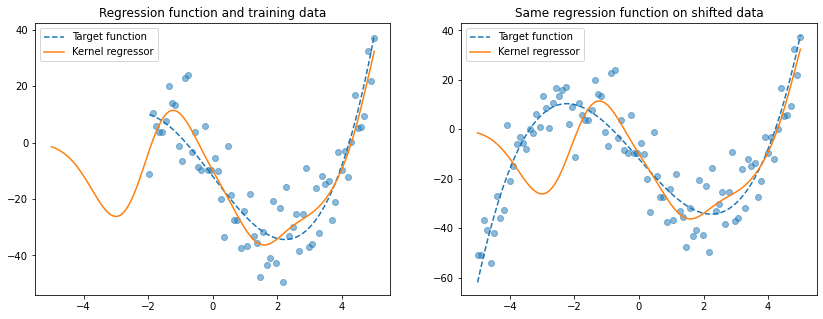

In [2]:
fig = plt.figure(figsize=(14, 5))

fig.add_subplot(1, 2, 1)
plt.plot(x_train_sub, target(x_train_sub), '--')
plt.plot(x_train_all, kernel_regressor_sub.predict(x_train_all))
plt.scatter(x_train_sub, y_train_sub, alpha=0.5)
plt.title("Regression function and training data")
plt.legend(['Target function', 'Kernel regressor'])

fig.add_subplot(1, 2, 2)
plt.plot(x_train_all, target(x_train_all), '--')
plt.plot(x_train_all, kernel_regressor_sub.predict(x_train_all))
plt.scatter(x_train_all, y_train_all, alpha=0.5)
plt.title("Same regression function on shifted data")
plt.legend(['Target function', 'Kernel regressor'])

plt.show()

#in the shifted data the kernal is not matching the target function

Since deep learning models can be viewed as hierarchical feature extractors (each layer extracts a feature of the data - as we go through the network they become more abstract features), we can encounter problems of **internal covariate shift**, where the activation values (values spat out by activation function) in hidden layers also undergo changes of distribution due to changes in parameter values and activations in earlier layers.

Internal covariate shift occurs due to the very nature of neural networks. After every batch is proccesed the weights are updated and further at every epoch of training different data is being processed (because the data is shuffled), which means that the inputs to a neuron is slightly different every time. As these changes get passed on to the next neuron, it creates a situation where the input distribution of every neuron is different at every epoch.

Normally, this is not a big deal, but in deep networks, these small changes in input distribution add up fast and amplify greatly deeper into the network. Ultimately, the input distribution received by the deepest neurons changes greatly between every epoch.

As a result, these neurons need to continuously adapt to the changing input distribution, meaning that their learning capabilities are severely bottlenecked. This constantly changing input distribution is called **internal covariate shift**.

Another issue that batch normalisation tackles is vanishing or exploding gradients. Before Rectified Linear Units (ReLUs), saturated activation functions were used. A saturated function is one that has a “flattened” curve towards to the left and right bounds, such as the sigmoid function.

<img src="figures/sigmoid.jfif" alt="Internal Covariate Shift" style="width: 250px;"/>

In the sigmoid function, the gradient tends towards 0 as the value of x tends towards ±∞. As a neural network is trained, the weights can be pushed towards the saturated ends of the sigmoid curve. As such, the gradient gets smaller and smaller and approaches 0. These small gradients get even smaller when multiplied together deeper into the network. When using backpropagation, the gradient gets exponentially closer to 0 and thus 'steps' towards convergance get smaller and smaller. This “**vanishing**” gradient severely limits the depth of networks.

Although this vanishing gradient can be easily managed by using a non-saturated activation function such as ReLU, batch normalisation still has a place as it prevents the weights from being pushed to those saturated regions in the first place, by ensuring no value has gone too high or low.

For a layer with $n_k$-dimensional input $\mathbf{h}^{(k)} = (h^{(k)}_1,\ldots,h^{(k)}_{n_k})$, we normalise each input feature

$$
\hat{h}^{(k)}_j = \frac{h^{(k)}_j - \mathbb{E}[h^{(k)}_j]}{\sqrt{\text{Var}[h^{(k)}_j]}}.
$$

In order to maintain full expressive power of the network, we make sure the final transformation can represent the identity:

$$
z^{(k)}_j = \gamma^{(k)}_j \hat{h}^{(k)}_j + \beta^{(k)}_j,
$$

where $\gamma^{(k)}_j$ and $\beta^{(k)}_j$ are learned parameters --KEY --(it learns the best mean and vairance for the features) . Note that setting $\gamma^{(k)}_j = \sqrt{\text{Var}[h^{(k)}_j]}$ and $\beta^{(k)}_j = \mathbb{E}[h^{(k)}_j]$ recovers the original activations. However, now the model can control the mean and variance of activations within the hidden layer $\mathbf{h}^{(k)}$ by tuning the parameters $\gamma^{(k)}_j$ and $\beta^{(k)}_j$. $\mathbf{z}^{(k)}$ then becomes the new input to the next layer in the network.

Statistics $\mathbb{E}[h^{(k)}_j]$ and $\text{Var}[h^{(k)}_j]$ are estimated over each minibatch $\mathcal{D}_m$ (that we train on):

$$
\begin{align}
\mu^{(k)}_{jm} &= \frac{1}{M} \sum_{i=1}^M h^{(k)}_{ij}\\
\left(\sigma^{(k)}_{jm}\right)^2 &= \frac{1}{M} \sum_{i=1}^M (h^{(k)}_{ij} - \mu^{(k)}_{jm})^2\\
\hat{h}^{(k)}_{j} &= \frac{h^{(k)}_{j} - \mu^{(k)}_{jm}}{\sqrt{\left(\sigma^{(k)}_{jm}\right)^2 + \epsilon}}\\
z^{(k)}_{j} &= \gamma^{(k)}_j\hat{h}^{(k)}_{j} + \beta^{(k)}_j =: BN_{\gamma^{(k)}, \beta^{(k)}}\left(h^{(k)}_{j}\right)
\end{align}
$$

where $M = |\mathcal{D}_m|$, and $h^{(k)}_{ij}$ is the activation value for the $j$-th for input $x_i\in\mathcal{D}_m$ in layer $k$.

The batch normalisation calculation is fully differentiable, and so gradients can be backpropagated through this calculation as normal. 

The batch normalisation operation is implemented as a layer in TensorFlow. In the following experiment we will recreate the first example from the [original paper](#Ioffe15) on the MNIST dataset.

In [3]:
import tensorflow as tf

In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Create Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset.element_spec

(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [5]:
# Normalise pixel values in the Datasets - converting image pixels to the range 0,1

def normalise_pixels(image, label):
    return (tf.cast(image, tf.float32) / 255., label)

train_dataset = train_dataset.map(normalise_pixels)
test_dataset = test_dataset.map(normalise_pixels)

In [6]:
# Shuffle and batch the dataset

train_dataset = train_dataset.shuffle(1000).batch(60)
test_dataset = test_dataset.batch(60)

In [7]:
x_train.shape

#we have 60000 28x28 pixel images! remember (batch_dims, input_shape).
# input_shape = (28, 28)

(60000, 28, 28)

In [8]:
# Build MLP - using functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input

#Functional API requires we explicitly define the input layer
inputs = Input(shape=(28, 28))

#Flattern pixel inputs into vector
h = Flatten()(inputs) #<-- remember to call it on the previous layer (inputs)

# Dense Layer. NOTE: kernal_init tells the layer how to initalise the (kernal) weight matrix 
h = Dense(100, activation='sigmoid', kernel_initializer=tf.random_normal_initializer)(h) #<-- again call on previous layer

# two more dense layers
h = Dense(100, activation='sigmoid', kernel_initializer=tf.random_normal_initializer)(h) 
h = Dense(100, activation='sigmoid', kernel_initializer=tf.random_normal_initializer)(h)

#output layer: needs to have 10 neurons representing each digit and put through softmax (outputs a probability vector)
outputs = Dense(10, activation='softmax')(h)

#Now bring it all together in Model Class!
model_without_BN = Model(inputs=inputs, outputs=outputs, name='Model_without_BN')

In [9]:
model_without_BN.summary(
)

Model: "Model_without_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
______________________________________________

In [10]:
#compile model
model_without_BN.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#fit our model - tupled together our train x and y into data.Dataset oject so just feed in!
history_without_BN = model_without_BN.fit(train_dataset, epochs=50, validation_data=test_dataset, verbose=False)

print('Training complete!')

Training complete!


#### Now rebuild model without Batch Normalisation and compare results!

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization

#Input layer
inputs = Input(shape=(28, 28))

#Flattern pixel inputs into vector
h = Flatten()(inputs) 

# Dense Layers sandwiches between BatchNormalisation Layers
h = Dense(100, activation='sigmoid', kernel_initializer=tf.random_normal_initializer)(h)
h = BatchNormalization()(h)
h = Dense(100, activation='sigmoid', kernel_initializer=tf.random_normal_initializer)(h)
h = BatchNormalization()(h)
h = Dense(100, activation='sigmoid', kernel_initializer=tf.random_normal_initializer)(h)
h = BatchNormalization()(h)

#output layer: needs to have 10 neurons representing each digit and put through softmax (outputs a probability vector)
outputs = Dense(10, activation='softmax')(h)

#Now bring it all together in Model Class!
model_with_BN = Model(inputs=inputs, outputs=outputs, name='Model_with_BN')
model_with_BN.summary()

Model: "Model_with_BN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_6 (Dense)              (None, 100)             

In [12]:
#compile
model_with_BN.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#fit
history_with_BN = model_with_BN.fit(train_dataset, epochs=50, validation_data=test_dataset, verbose=False)

print('Training complete!')

Training complete!


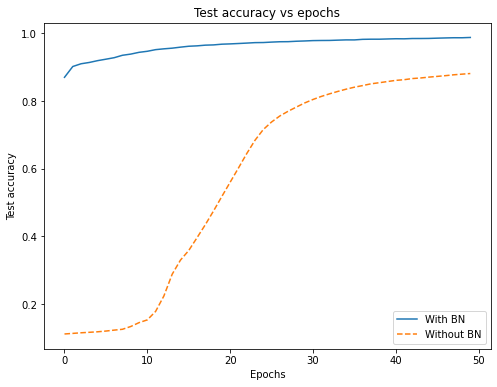

In [15]:
# Plot the test accuracy

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(history_with_BN.history['accuracy'])
plt.plot(history_without_BN.history['accuracy'], '--')
plt.legend(['With BN', 'Without BN'])
plt.ylabel("Test accuracy")
plt.xlabel("Epochs")
plt.title("Test accuracy vs epochs")
plt.show()

We see clearly in the above plot that the batch normalisation layers help the model to train faster, and to a higher accuracy. Batch normalisation reduces internal covariate shift, particularly early on in training. The distribution is more stable, making learning easier.

## Reference

<a class="anchor" id="Ioffe15"></a>
* Ioffe, S. & Szegedy, C., "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", in *Proceedings of the 32nd International Conference on International Conference on Machine Learning*, **37**, 448–456.